In [167]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [168]:
def load_fold_data(experiment_dir, fold, epoch):
    """
    Generalized function to load fold data from a given experiment directory.

    Args:
        experiment_dir (str): The directory path where the experiment data is stored.
        num_folds (int): Number of folds (e.g., 3 for fold_0, fold_1, fold_2).
        epoch (int): Epoch number to be loaded (e.g., 0 for epoch_0).

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data of all folds with fold information.
    """
    file_path = os.path.join(
        experiment_dir, f"fold_{fold}_epoch_{epoch}_metrics.csv"
    )

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["fold"] = fold
        return df
    else:
        print(f"Warning: File {file_path} does not exist.")

In [169]:
register_df = pd.read_csv("/net/scratch/cmosig/segmentation_meta/tiles_2025/register.csv")

In [170]:
experiment_dir = "/net/scratch/cmosig/experiment_dir_deadwood_segmentation/segformer_b5_oversample_newdata/"

frames = []
for epoch in [0] + list(range(14, 105, 15)):
# for epoch in [0] + list(range(14, 200, 15)):
    for fold in [0,1,2]:
        frames.append(load_fold_data( experiment_dir, fold, epoch))

metrics_df = pd.concat(frames, ignore_index=True)
metrics_df

,precision_0.1,precision_0.2,precision_0.3,precision_0.4,precision_0.5,precision_0.6,precision_0.7,precision_0.8,precision_0.9,recall_0.1,...,iou_0.3,iou_0.4,iou_0.5,iou_0.6,iou_0.7,iou_0.8,iou_0.9,register_index,epoch,fold
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8895.0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8896.0,0,0
2,0.002323,0.002511,0.002729,0.002976,0.003289,0.003612,0.003969,0.004301,0.004714,0.930582,...,0.002728,0.002974,0.003287,0.003610,0.003966,0.004296,0.004707,8897.0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8898.0,0,0
4,0.009634,0.010157,0.010785,0.011464,0.012250,0.012969,0.013880,0.014613,0.015595,0.773363,...,0.010733,0.011392,0.012152,0.012839,0.013707,0.014387,0.015300,8899.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553115,0.919085,0.919186,0.919288,0.919436,0.919696,0.919793,0.920058,0.920380,0.920655,0.863621,...,0.802556,0.802471,0.802472,0.802398,0.802451,0.802548,0.802708,377337.0,104,2
2553116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,377338.0,104,2
2553117,0.414293,0.414950,0.415545,0.415772,0.416288,0.416535,0.417063,0.417610,0.417761,0.541939,...,0.307407,0.307284,0.307317,0.307243,0.307406,0.307619,0.307450,2342.0,104,2
2553118,0.291166,0.291516,0.291491,0.291805,0.292424,0.292564,0.292527,0.292705,0.293061,0.767221,...,0.267516,0.267684,0.268205,0.268225,0.268096,0.268245,0.268544,2343.0,104,2


In [171]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metrics_df = metrics_df[
    (metrics_df[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
    & (metrics_df[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
    & (metrics_df[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
]
register_metrics = pd.merge(
    register_df, metrics_df, right_on="register_index", left_index=True
)
register_metrics.columns

Index(['base_file_name', 'file_path', 'global_file_path', 'resolution', 'x',
       'y', 'label_quality', 'mask_filled', 'resolution_bin', 'original',
       'biome', 'biome_group', 'precision_0.1', 'precision_0.2',
       'precision_0.3', 'precision_0.4', 'precision_0.5', 'precision_0.6',
       'precision_0.7', 'precision_0.8', 'precision_0.9', 'recall_0.1',
       'recall_0.2', 'recall_0.3', 'recall_0.4', 'recall_0.5', 'recall_0.6',
       'recall_0.7', 'recall_0.8', 'recall_0.9', 'f1_0.1', 'f1_0.2', 'f1_0.3',
       'f1_0.4', 'f1_0.5', 'f1_0.6', 'f1_0.7', 'f1_0.8', 'f1_0.9', 'iou_0.1',
       'iou_0.2', 'iou_0.3', 'iou_0.4', 'iou_0.5', 'iou_0.6', 'iou_0.7',
       'iou_0.8', 'iou_0.9', 'register_index', 'epoch', 'fold'],
      dtype='object')

In [238]:
import matplotlib.colors as mcolors
import numpy as np

def create_green_colormap(steps=256):
    # Create color segments from white to dark green
    colors = [(1, 1, 1),          # White
             (0.8, 0.95, 0.8),    # Very light green
             (0.4, 0.8, 0.4),     # Light green
             (0, 0.6, 0),         # Medium green
             (0, 0.3, 0)]         # Dark green
    
    # Create colormap
    n_bins = steps
    green_cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_green', colors, N=n_bins)
    
    return green_cmap

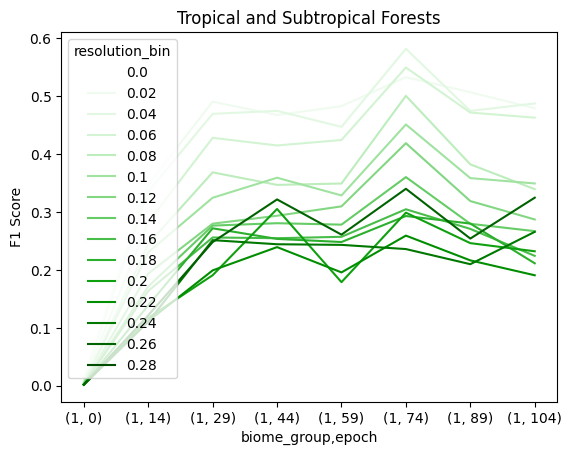

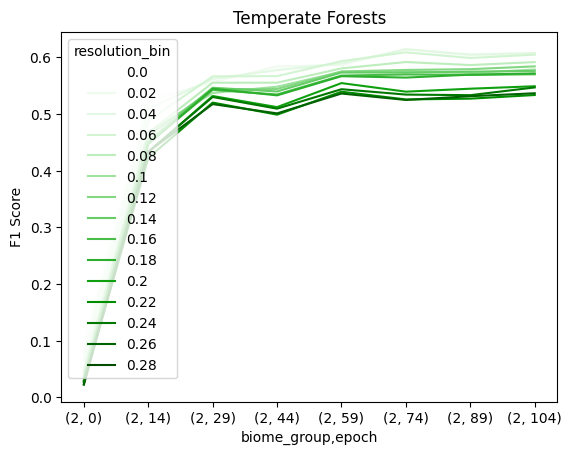

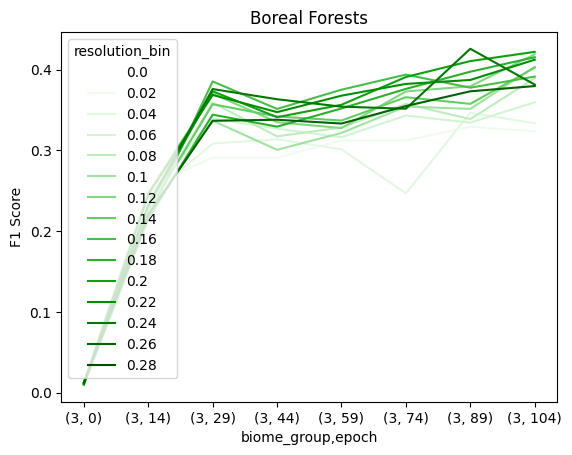

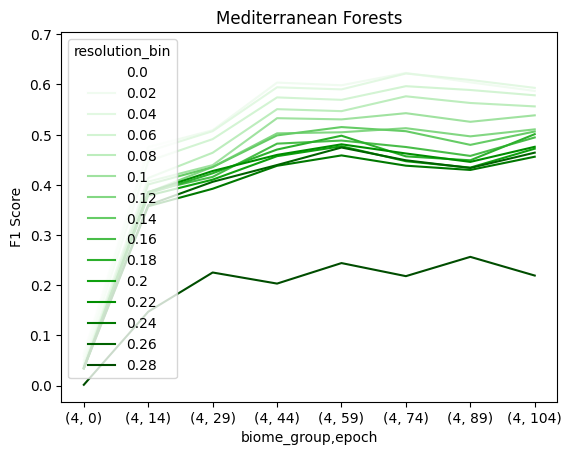

In [241]:
# sub_df = register_metrics[register_metrics["fold"] == 1]

BIOMEGROUPINGS = {
    "Tropical and Subtropical Forests": [1, 2, 3, 14, 7],
    "Temperate Forests": [4, 5, 8],
    "Boreal Forests": [6, 11, 10],
    "Mediterranean Forests": [12, 13, 9],
}

register_metrics["biome_res"] = register_metrics[["biome_group", "resolution_bin"]].apply(tuple, axis=1)

spread = "resolution_bin" 


mean_metrics = register_metrics[register_metrics["fold"] == 0].groupby([spread, "biome_group", "epoch"]).agg({"f1_0.5": "mean", "recall_0.5": "mean", "precision_0.5": "mean"}).reset_index()

mean_metrics_pivot = mean_metrics.pivot(columns=spread, index=["biome_group", "epoch"], values="f1_0.5")
axes = mean_metrics_pivot.groupby(["biome_group"]).plot(colormap=create_green_colormap(steps=15))

for i, ax in enumerate(axes):
    ax.set_ylabel("F1 Score")
    ax.set_title(list(BIOMEGROUPINGS.keys())[i])

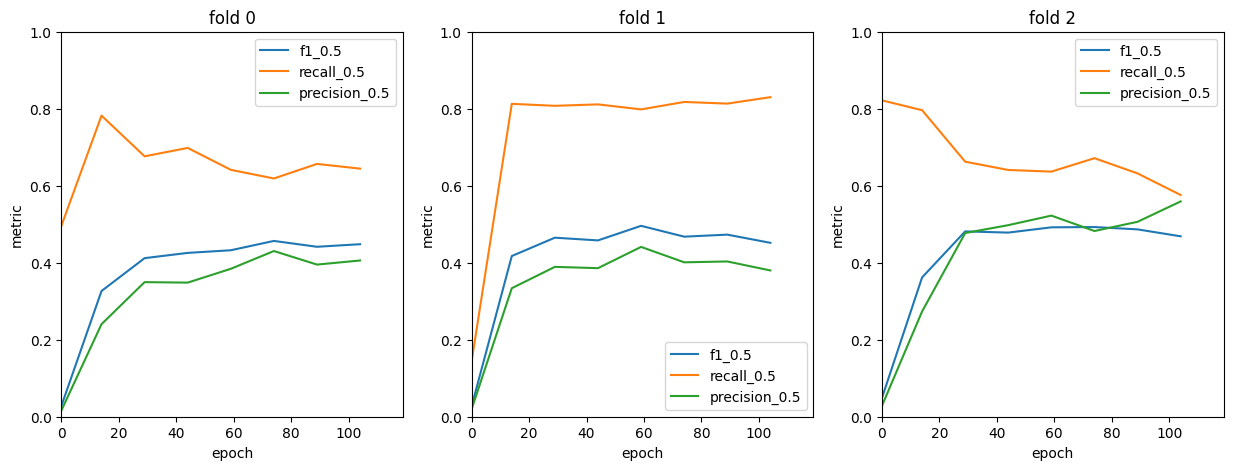

In [209]:
mean_metrics = register_metrics.groupby(["fold", spread, "biome_group", "epoch"]).agg({"f1_0.5": "mean", "recall_0.5": "mean", "precision_0.5": "mean"}).reset_index()

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

# mean_metrics = mean_metrics[mean_metrics["resolution_bin"] == 0.02]

for i, (key, group) in enumerate(mean_metrics.groupby("fold")):
    axes[i].set_ylim((0,1))
    axes[i].set_xlim((0,119))
    axes[i].set_title("fold " + str(key))
    axes[i].set_ylabel("metric")
    group.groupby(["epoch"])[["f1_0.5","recall_0.5","precision_0.5"]].mean().plot(ax=axes[i])

Text(0, 0.5, 'metric')

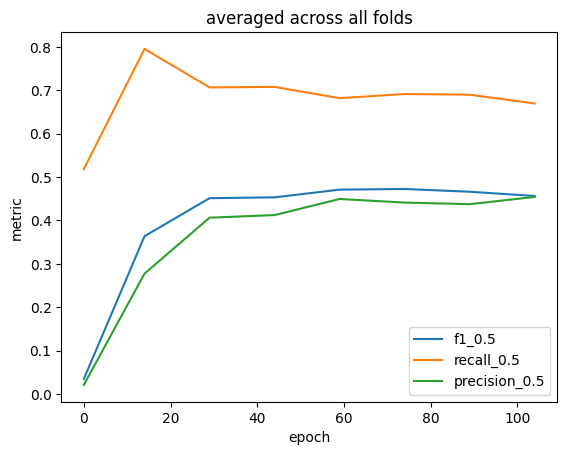

In [210]:
ax = mean_metrics.groupby(["epoch"])[["f1_0.5","recall_0.5","precision_0.5"]].mean().plot()
ax.set_title("averaged across all folds")
ax.set_ylabel("metric")

In [237]:
BIOMEGROUPINGS = {
    "(Sub) Tropical": [1, 2, 3, 14, 7],
    "Temperate": [4, 5, 8],
    "Boreal and Montane": [6, 11, 10],
    "Drylands": [12, 13, 9],
}

BIOMEGROUPINGS_INDEX_NAME = dict(zip(range(1, len(BIOMEGROUPINGS.keys()) + 1), BIOMEGROUPINGS.keys()))
BIOMEGROUPINGS_INDEX_NAME

biome_table = mean_metrics.copy()

biome_table = biome_table.rename(columns={"biome_group":"Biome Group"})

biome_table = biome_table[biome_table["epoch"] == 104].groupby("Biome Group")[["f1_0.5","recall_0.5","precision_0.5"]].mean()
biome_table.index = biome_table.index.map(BIOMEGROUPINGS_INDEX_NAME)

biome_table.columns = ["F1", "Recall", "Precision"]

biome_table = biome_table.round(2)
biome_table["F1"] = biome_table["F1"].astype(str)
biome_table["Precision"] = biome_table["Precision"].astype(str)
biome_table["Recall"] = biome_table["Recall"].astype(str)

print(biome_table.to_latex())

\begin{tabular}{llll}
\toprule
 & F1 & Recall & Precision \\
Biome Group &  &  &  \\
\midrule
(Sub) Tropical & 0.34 & 0.45 & 0.53 \\
Temperate & 0.57 & 0.77 & 0.51 \\
Boreal and Montane & 0.38 & 0.72 & 0.29 \\
Drylands & 0.49 & 0.65 & 0.5 \\
\bottomrule
\end{tabular}

